In [1]:
# This should be in a function...

def GetChildren(iCurrentParticle, pfpSelfList, pfpParentSelfList, childrenSelfList) :
    
    childrenSelfList.append(iCurrentParticle)
    
    for iParticle in range(pfpParentSelfList.shape[0]) :
        if (pfpParentSelfList[iParticle] == pfpSelfList[iCurrentParticle]) :
            GetChildren(iParticle, pfpSelfList, pfpParentSelfList, childrenSelfList)


In [2]:
# This should be in a function...

def GetIvysaurusScore(iCurrentParticle, pfpTruePDGList, pfpIvysaurusMuonList, pfpIvysaurusProtonList, pfpIvysaurusPionList, pfpIvysaurusPhotonList, pfpIvysaurusElectronList) :
    
    absPDG = abs(pfpTruePDGList[iCurrentParticle])
    
    if (absPDG == 13) :
        return pfpIvysaurusMuonList[iCurrentParticle]
    elif (absPDG == 2212) :
        return pfpIvysaurusProtonList[iCurrentParticle]
    elif (absPDG == 211) :
        return pfpIvysaurusPionList[iCurrentParticle]
    elif (absPDG == 22) :
        return pfpIvysaurusPhotonList[iCurrentParticle]
    elif (absPDG == 11) :
        return pfpIvysaurusElectronList[iCurrentParticle]
    else :
        return -1

In [3]:
# Alright, lets begin...

In [4]:
# for creating a responsive plot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl

In [5]:
import uproot
import VisualisationFileHelper
import GraphBuilder

In [6]:
from termcolor import colored, cprint

# Colour Dictionaries
pdgColours_text = {13 : 'blue', 11 : 'red', 2212 : 'green', 211 : 'magenta', 22 : 'yellow'}
pdgColours_graph = {13 : 'blue', 11 : 'red', 2212 : 'green', 211 : 'pink', 22 : 'tab:orange'}
hierarchyColours = {1 : 'black', 2 : 'red', 3 : 'blue', 4: 'g'}

In [7]:
# Target event info

#fileName = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/nu_dune10kt_1x2x6_1421_369_20230827T093357Z_gen_g4_detsim_hitreco_ccnutree.root'
fileName = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/nue_dune10kt_1x2x6_1124_526_20230828T185125Z_gen_g4_detsim_hitreco_ccnutree.root'
targetRun = 1124
targetSubrun = 1
targetEvent = 52611


In [8]:
treeFile = uproot.open(fileName)
tree = treeFile['ccnuselection/ccnusel']
branches = tree.arrays()

run = np.array(branches['Run'])
subrun = np.array(branches['SubRun'])
event = np.array(branches['Event'])

print('run: ', run)
print('subrun: ', subrun)
print('event: ', event)

run:  [1124 1124 1124 1124 1124 1124 1124 1124 1124 1124]
subrun:  [1 1 1 1 1 1 1 1 1 1]
event:  [52611 52612 52613 52614 52615 52616 52617 52618 52619 52620]


In [9]:
# Read the file

isNC, nuPDG, recoNuX, recoNuY, recoNuZ, \
pfpSelf, pfpRecoGeneration, pfpRecoParentSelf, \
trackRecoStartX, trackRecoStartY, trackRecoStartZ, \
pfpSpacepointX, pfpSpacepointY, pfpSpacepointZ, \
pfpTrackShowerScore, pfpNHits, pfpCharge, \
pfpRecoVertexX, pfpRecoVertexY, pfpRecoVertexZ, \
trackRecoEndX, trackRecoEndY, trackRecoEndZ, \
showerDirX, showerDirY, showerDirZ, \
pfpIvysaurusMuon, pfpIvysaurusProton, pfpIvysaurusPion, \
pfpIvysaurusPhoton, pfpIvysaurusElectron, \
pfpTrackLength, pfpDisplacement, pfpDCA, pfpIsNeutrinoPDG, \
pfpNuVertexEnergyAsymmetry, pfpNuVertexEnergyWeightedMeanRadialDistance, \
pfpTrueMomX, pfpTrueMomY, pfpTrueMomZ, \
pfpTrueTrackID, pfpCompleteness, pfpPurity, pfpTruePDG, pfpTrueGeneration, \
pfpTrueParentTrackID, pfpTrueParentPDG, pfpTrueVisibleGeneration, \
pfpTrueVisibleParentTrackID, pfpTrueVisibleParentPDG = VisualisationFileHelper.readTree(fileName, targetRun, targetSubrun, targetEvent)

nParticles = pfpTruePDG.shape[0]

This should be one:  1


In [10]:
jam = 4

dictjam = {'frog' : jam}

print(dictjam)

dictjam['frog'] = 2

print(dictjam)
print(jam)

{'frog': 4}
{'frog': 2}
4


In [11]:
# Get hierarchy in print format

childrenSelfList = []

for iParticle in range(nParticles) : 
    if (pfpRecoGeneration[iParticle] == 2) :
        GetChildren(iParticle, pfpSelf, pfpRecoParentSelf, childrenSelfList)
      

In [12]:
#Print out the hierarchy
        
print(('CC' if not isNC else 'NC'), ('nue' if nuPDG == 12 else ('numu' if nuPDG == 14 else 'nutau')))
        
for iParticle in childrenSelfList :
    
    if (np.array(pfpSpacepointX[iParticle]).shape[0] == 0) :
        continue
    
    if (pfpRecoGeneration[iParticle] == 2) :
        print('-------------------------------------')
    
    space = "------" * (pfpRecoGeneration[iParticle] - 2) + " "
    
    print(space + 'Matched TrackID:', str(pfpTrueTrackID[iParticle]) + ', Matched Particle PDG:', colored(pfpTruePDG[iParticle], pdgColours_text.get(abs(pfpTruePDG[iParticle]), 'light_grey')))
    print(space + 'Ivysaurus Score:', GetIvysaurusScore(iParticle, pfpTruePDG, pfpIvysaurusMuon, \
          pfpIvysaurusProton, pfpIvysaurusPion, pfpIvysaurusPhoton, pfpIvysaurusElectron))
    print(space, ' True: Generation =', str(pfpTrueGeneration[iParticle]) + \
          ', Parent TrackID =', str(pfpTrueParentTrackID[iParticle]) + \
          ', Parent PDG =', colored(pfpTrueParentPDG[iParticle], pdgColours_text.get(abs(pfpTrueParentPDG[iParticle]), 'light_grey')))
    print(space, ' True Visible: Generation =', str(pfpTrueVisibleGeneration[iParticle]) + \
          ', Parent TrackID =', str(pfpTrueVisibleParentTrackID[iParticle]) + \
          ', Parent PDG =', colored(pfpTrueVisibleParentPDG[iParticle], pdgColours_text.get(abs(pfpTrueVisibleParentPDG[iParticle]), 'light_grey')))

print('-------------------------------------')

CC nue
-------------------------------------
 Matched TrackID: 4, Matched Particle PDG: 211
 Ivysaurus Score: 0.9301020503044128
   True: Generation = 2, Parent TrackID = 0, Parent PDG = -1
   True Visible: Generation = 2, Parent TrackID = 0, Parent PDG = -1
------ Matched TrackID: 231, Matched Particle PDG: 2212
------ Ivysaurus Score: 1.0
------   True: Generation = 4, Parent TrackID = 50, Parent PDG = 211
------   True Visible: Generation = 4, Parent TrackID = 50, Parent PDG = 211
------ Matched TrackID: 50, Matched Particle PDG: 211
------ Ivysaurus Score: 0.9772971868515015
------   True: Generation = 3, Parent TrackID = 4, Parent PDG = 211
------   True Visible: Generation = 3, Parent TrackID = 4, Parent PDG = 211
------------ Matched TrackID: 232, Matched Particle PDG: 2212
------------ Ivysaurus Score: 0.9877954721450806
------------   True: Generation = 4, Parent TrackID = 50, Parent PDG = 211
------------   True Visible: Generation = 4, Parent TrackID = 50, Parent PDG = 211
-

-------------------------------------


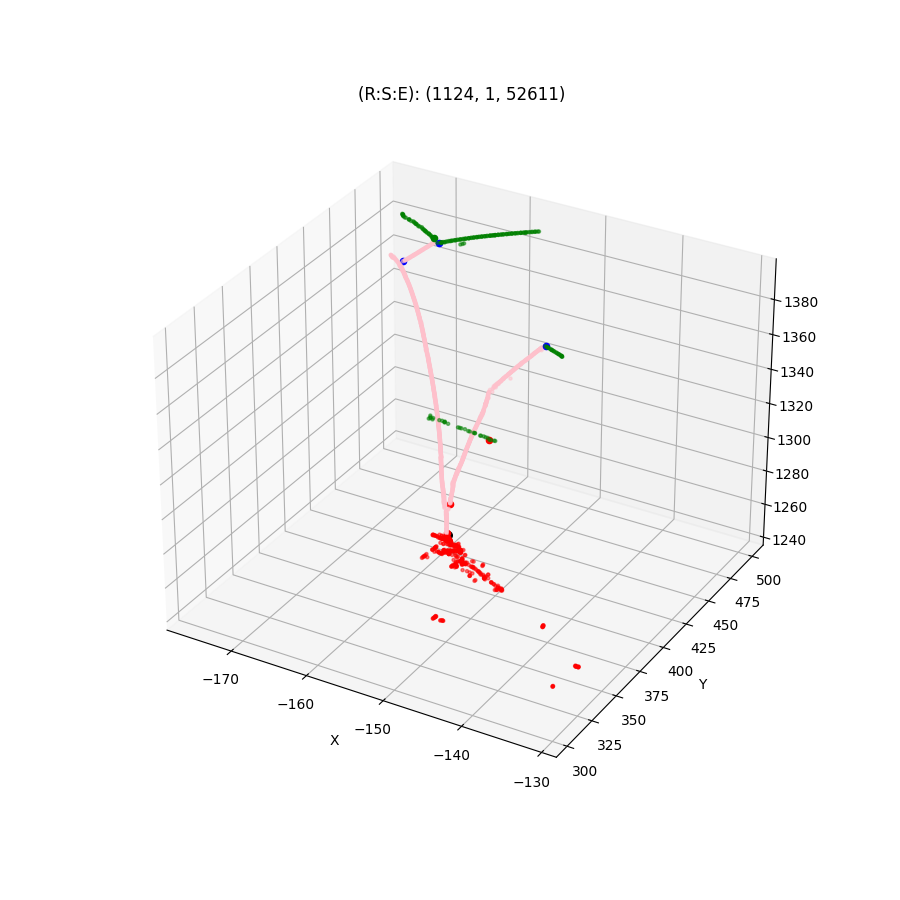

In [13]:
# NuVertex
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')

ax.scatter(recoNuX, recoNuY, recoNuZ, color = "black", s = 30.0)
plt.title('(R:S:E): (' + str(targetRun) + ", " + str(targetSubrun) + ", " + str(targetEvent) + ")")
plt.xlabel('X')
plt.ylabel('Y')

for iParticle in range(nParticles) : 
    
    if (np.array(pfpSpacepointX[iParticle]).shape[0] == 0) :
        continue
    
    x = np.array(pfpSpacepointX[iParticle])
    y = np.array(pfpSpacepointY[iParticle])
    z = np.array(pfpSpacepointZ[iParticle])
    
    vertexX = pfpRecoVertexX[iParticle]
    vertexY = pfpRecoVertexY[iParticle]
    vertexZ = pfpRecoVertexZ[iParticle]
    
    ax.scatter(x, y, z, color = pdgColours_graph.get(abs(pfpTruePDG[iParticle]), 'tab:gray'), s = 5.0, alpha = 0.5)
    ax.scatter(vertexX, vertexY, vertexZ, color = hierarchyColours.get(pfpRecoGeneration[iParticle], 'tab:gray'), s = 20.0)


print('-------------------------------------')

# show plot
plt.show()

#### plot only reco.. 

In [14]:
# Construct the graph building dictionary

eventDict = {
    "recoNuVertexX"                            : recoNuX, \
    "recoNuVertexY"                            : recoNuY, \
    "recoNuVertexZ"                            : recoNuZ, \
    "nParticles"                               : nParticles, \
    "trackShowerScore"                         : pfpTrackShowerScore, \
    "nHits"                                    : pfpNHits, \
    "charge"                                   : pfpCharge, \
    "vertexX"                                  : pfpRecoVertexX, \
    "vertexY"                                  : pfpRecoVertexY, \
    "vertexZ"                                  : pfpRecoVertexZ, \
    "trackEndX"                                : trackRecoEndX, \
    "trackEndY"                                : trackRecoEndY, \
    "trackEndZ"                                : trackRecoEndZ, \
    "showerDirX"                               : showerDirX, \
    "showerDirY"                               : showerDirY, \
    "showerDirZ"                               : showerDirZ, \
    "ivysaurusMuon"                            : pfpIvysaurusMuon, \
    "ivysaurusProton"                          : pfpIvysaurusProton, \
    "ivysaurusPion"                            : pfpIvysaurusPion, \
    "ivysaurusElectron"                        : pfpIvysaurusElectron, \
    "ivysaurusPhoton"                          : pfpIvysaurusPhoton, \
    "trackLength"                              : pfpTrackLength, \
    "displacement"                             : pfpDisplacement, \
    "dca"                                      : pfpDCA, \
    "isNeutrinoPDG"                            : pfpIsNeutrinoPDG, \
    "nuVertexEnergyAsymmetry"                  : pfpNuVertexEnergyAsymmetry, \
    "nuVertexEnergyWeightedMeanRadialDistance" : pfpNuVertexEnergyWeightedMeanRadialDistance, \
    "trueTrackID"                              : pfpTrueTrackID, \
    "trueVisibleParentTrackID"                 : pfpTrueVisibleParentTrackID, \
    "trueMomX"                                 : pfpTrueMomX, \
    "trueMomY"                                 : pfpTrueMomY, \
    "trueMomZ"                                 : pfpTrueMomZ, \
    "truePDG"                                  : pfpTruePDG
}

modeDict = {
    "ADD_NEUTRINO"                 : True,
    "CHEAT_DIRECTION"              : True,
    "CHEAT_PID"                    : True, 
    "MAKE_PARTICLE_PARTICLE_LINKS" : True,
    "EDGE_FRACTION"                : 0.8,
    "DO_NORMALISATION"             : True,
    "IS_TRAINING_MODE"             : False
}

print(eventDict['trackLength'])


[133.83638     91.46549988 182.48144531  22.96453857  14.91156483
   9.75864887  10.19823837   8.67840385]


In [15]:
data_pos, data_neg, data_FC = GraphBuilder.GraphBuilder(eventDict, modeDict)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
print(data_neg.num_edges) 

0
